In [1]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap
import yfinance

from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mplfinance.original_flavor import candlestick_ohlc


In [2]:
class MeasureTime:
    def __init__(self):
        self.start = time.time()
    def kill(self):
        print ('Time elapsed: ' + time.strftime("%H:%M:%S", time.gmtime(time.time()-self.start)))
        del self

In [3]:
Notebook_timer = MeasureTime()
Notebook_timer.kill()

Time elapsed: 00:00:00


In [4]:

def get_stock_dataframe(ticker , startDate , endDate):
  #Get the stock
  df = datard.DataReader(ticker, 'stooq', startDate, endDate , '1h')
  #Reverse the data frame
  df = df.iloc[::-1]
  return df
  
ticker = 'AAPL'
endDate = pd.to_datetime('today')
startDate = endDate - timedelta(days = 365 * 32 )

df = yfinance.download(ticker , startDate , endDate )
# df = get_stock_dataframe(ticker , startDate , endDate , i)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-03-26,0.379464,0.387277,0.375000,0.377232,0.302765,128060800
1990-03-27,0.375000,0.377232,0.368304,0.375000,0.300974,84604800
1990-03-28,0.375000,0.376116,0.366071,0.368304,0.295600,102939200
1990-03-29,0.366071,0.370536,0.363839,0.367188,0.294704,96891200
1990-03-30,0.357143,0.366071,0.357143,0.359375,0.288433,223350400
...,...,...,...,...,...,...
2022-03-09,161.479996,163.410004,159.410004,162.949997,162.949997,91454900
2022-03-10,160.199997,160.389999,155.979996,158.520004,158.520004,105342000
2022-03-11,158.929993,159.279999,154.500000,154.729996,154.729996,96836300


In [5]:
del df['Adj Close']
del df['Volume']

lookback = 3 # >=3 number of days for recognizing candle pattern 

In [6]:
# Timestep = List of candles seqeuence
# Items = Candlestick
# Features = High, Low, Open, Close parametes
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]

    date = range(len(closep))

    x = 0
    y = len(date)
    ohlc = []

    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x += 1

    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
        
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


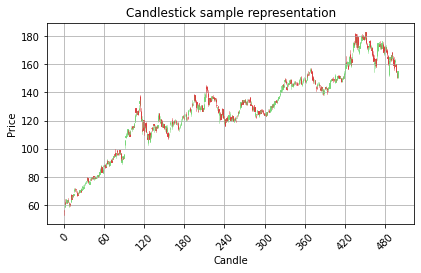

In [7]:
graph_data_ohlc(df.tail(500).values)

In [8]:
#Custom generator function to create 3d arrays of candles sequence
#We will look for patterns based on the last 3 candles. 
#To do so, we need to change the format of our dataset to 3 dimensional array (Timestep, Items, Features) .
def my_generator(data,lookback):
    final_output = []
    counter = 0
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row: first_row + lookback]:
            temp_list.append(candle)
            
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row + 1
    return arr

In [9]:
cell_timer = MeasureTime()
three_dim_sequence = np.asarray(my_generator(df.values[0:], lookback))
cell_timer.kill()

Time elapsed: 00:00:00


In [10]:
three_dim_sequence.shape

(8054, 3, 4)

Step 1


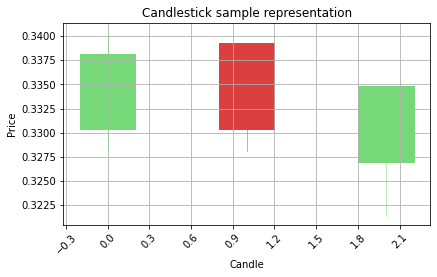

Step 2


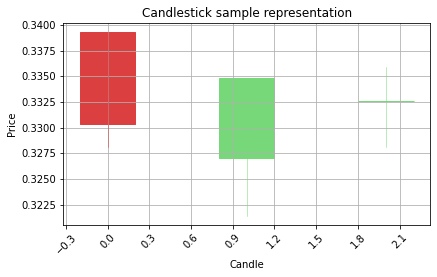

Step 3


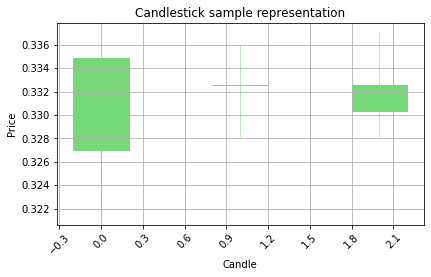

Step 4


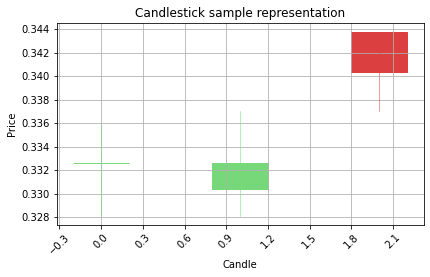

Step 5


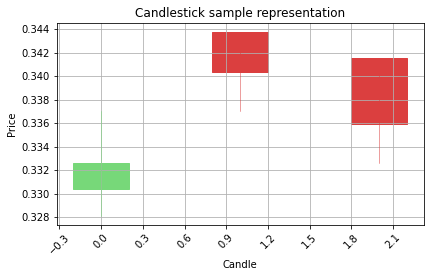

In [11]:
counter=0
for candle in three_dim_sequence[1000:1005]:
    counter=counter+1
    print('Step ' + str(counter))
    graph_data_ohlc(candle)

In [12]:
# convert the price data in to actual candlestick parameters. Each candle has 4 parameters
# Open	High Low	Close -< conversion_array
# Size of the body measured by pips
# Size of the upper wicks measured by pips
# Size of the lower wicks measured by pips
# Type of the candle (Bullish or Bearish)(Green or Red)(0 or 1)


#Handle
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000, 4)
    candlestick_data[2]=round(round(wicks_down,5)*10000, 4)
    candlestick_data[3]=round(round(body_size,5)*10000, 4)

    return candlestick_data

In [13]:
cell_timer = MeasureTime()
one_candle_data_ohlc=three_dim_sequence[1000:1010][5][1]
cell_timer.kill()

Time elapsed: 00:00:00


In [14]:
one_candle_data_ohlc

array([0.34151801, 0.34151801, 0.332589  , 0.33593801])

In [15]:
one_candle_data_ohlc_candle=ohlc_to_candlestick(one_candle_data_ohlc)

In [16]:
one_candle_data_ohlc_candle

[0, 0.0, 33.5, 55.8]

In [17]:
#Apply this function in to generator function to get sequences with candlestick data instead of OHLC data
def my_generator_candle(data,lookback):
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    for a in range(len(data)-lookback):
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
        first_row=first_row+1
    return arr

In [18]:
three_dim_sequence_candle=my_generator_candle(df.values[1:], lookback)
three_dim_sequence_candle[1000:1005]

array([[[ 0. ,  0. , 22.3, 89.3],
        [ 1. ,  0. , 55.8, 78.1],
        [ 0. , 33.5, 44.6, 33.5]],

       [[ 1. ,  0. , 55.8, 78.1],
        [ 0. , 33.5, 44.6, 33.5],
        [ 1. , 44.7, 22.3, 22.3]],

       [[ 0. , 33.5, 44.6, 33.5],
        [ 1. , 44.7, 22.3, 22.3],
        [ 0. ,  0. , 33.5, 33.5]],

       [[ 1. , 44.7, 22.3, 22.3],
        [ 0. ,  0. , 33.5, 33.5],
        [ 0. ,  0. , 33.5, 55.8]],

       [[ 0. ,  0. , 33.5, 33.5],
        [ 0. ,  0. , 33.5, 55.8],
        [ 0. , 22.3, 22.3, 89.3]]])

In [19]:
def ShootingStar(candle , prev_candle):
    close = candle[3]
    open = candle[0]
    high = candle[1]
    low = candle[2]

    prev_close = prev_candle[3]
    prev_open = prev_candle[0]
    prev_high = prev_candle[1]
    prev_low = prev_candle[2]

    return (prev_open < prev_close < open and
                high - max(open, close) >= abs(open - close) * 3 and
                min(close, open) - low <= abs(open - close))

In [20]:
def EveningStar(candle , prev_candle , b_prev_candle):
    close = candle[3]
    open = candle[0]
    high = candle[1]
    low = candle[2]

    prev_close = prev_candle[3]
    prev_open = prev_candle[0]
    prev_high = prev_candle[1]
    prev_low = prev_candle[2]

    b_prev_close = b_prev_candle[3]
    b_prev_open = b_prev_candle[0]
    b_prev_high = b_prev_candle[1]
    b_prev_low = b_prev_candle[2]

    return (min(prev_open, prev_close) > b_prev_close > b_prev_open and
                close < open < min(prev_open, prev_close))

In [21]:
def BearishEngulfing(candle , prev_candle):
    close = candle[3]
    open = candle[0]
    high = candle[1]
    low = candle[2]

    prev_close = prev_candle[3]
    prev_open = prev_candle[0]
    prev_high = prev_candle[1]
    prev_low = prev_candle[2]

    return (open >= prev_close > prev_open and
                open > close and
                prev_open >= close and 
                open - close > prev_close - prev_open)

In [22]:
def DragonflyDoji(candle):

    close = candle[3]
    open = candle[0]
    high = candle[1]
    low = candle[2]

    return abs(close - open) / (high - low) < 0.1 and \
            (min(close, open) - low) > (3 * abs(close - open)) and \
            (high - max(close, open)) < abs(close - open)

In [23]:
#Function preprocessing the data to clasiffy it into 3 relevant array

#arr : converted data array using ohlc_to_candlestick
# arr3 : raw data array
# arr2: preditcion

# ShootingStar
# EveningStar
# BearishEngulfing
# DragonflyDoji

def my_generator_candle_X_Y(data,lookback,MinMax = False  , isPattern = False):
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    first_row = 0
    arr = np.empty((0,lookback,4))

    arr3 = np.empty((0,lookback,4))
    
    Y_list = []
    for a in range(len(data)-lookback):
        curr_data = data[first_row + lookback - 1]
        prev_data = data[first_row + lookback - 2]
        b_prev_data = data[first_row + lookback - 3]
        temp_list = []
        temp_list_raw = []

        if (( DragonflyDoji(curr_data) ) | ( BearishEngulfing(curr_data , prev_data) ) 
            | ( ShootingStar(curr_data , prev_data )) | (EveningStar(curr_data , prev_data , b_prev_data)) | isPattern):
            for candle in data[first_row:first_row+lookback]:
                converted_data = ohlc_to_candlestick(candle)
                temp_list.append(converted_data)
                temp_list_raw.append(candle)

            temp_list3 = [np.asarray(temp_list)]
            templist4 = np.asarray(temp_list3)
            
            if MinMax==True:
                templist99 = scaler.fit_transform(templist4[0])
                arr = np.append(arr, [templist99], axis=0)
            else:
                arr = np.append(arr, templist4, axis=0)

            temp_list7 = [np.asarray(temp_list_raw)]
            templist8 = np.asarray(temp_list7)
            arr3 = np.append(arr3, templist8, axis=0)

            converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])

            Prediction = converted_data_prediction[0]
            Y_list.append(Prediction)

        
        first_row=first_row + 1

    arr2 = np.asarray(Y_list)

    return arr,arr2,arr3

In [24]:
# X : converted data array using ohlc_to_candlestick
# X_raw : raw data array
# Y: preditcion
cell_timer = MeasureTime()
X,Y, X_raw = my_generator_candle_X_Y(df.values, lookback ,MinMax=False , isPattern= False )
cell_timer.kill()

Time elapsed: 00:00:00


In [25]:
Y.shape

(581,)

In [26]:
X.shape

(581, 3, 4)

In [27]:
unique, counts = np.unique(Y, return_counts=True)
predictions_type = dict(zip(unique, counts))
print('Bull: ' + str((predictions_type[1])) + ' percent: ' + str(round((predictions_type[1]*100)/len(Y),2)) + '%')
print('Bear: ' + str((predictions_type[0])) + ' percent: ' + str(round((predictions_type[0]*100)/len(Y),2)) + '%')
print('Total: ' + str(len(Y)))

Bull: 307 percent: 52.84%
Bear: 274 percent: 47.16%
Total: 581


In [28]:
print('Shape of X ' + str(X.shape))
print('Shape of Y ' + str(Y.shape))
print('Shape of X raw ohlc ' + str(X_raw.shape))

Shape of X (581, 3, 4)
Shape of Y (581,)
Shape of X raw ohlc (581, 3, 4)


In [29]:
# for a in range(5):
#     b=a+1000
#     if Y[b] == 1:print('Correct prediction would be Bullish ---^')
#     if Y[b] == 0:print('Correct prediction would be Bearish ---v')
#     graph_data_ohlc(X_raw[b])

In [30]:
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(layers.LSTM(units = 50,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(Dropout(0.3))
model.add(layers.LSTM(units = 50,return_sequences=True ))
model.add(Dropout(0.3))
model.add(layers.LSTM(units = 50))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          11000     
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, None, 50)          20200     
                                                                 
 dropout_1 (Dropout)         (None, None, 50)          0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [32]:
cell_timer = MeasureTime()
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5 , shuffle = False)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5 , shuffle = False)

X_train_raw, X_val_and_test_raw = train_test_split(X_raw, test_size=0.5 , shuffle = False )
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.5 , shuffle = False)
cell_timer.kill()

Time elapsed: 00:00:00


In [33]:
print('Training data: ' + 'X Input shape: ' + str(X_train.shape) + ', ' + 'Y Output shape: ' + str(Y_train.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))
print('Validation data: ' + 'X Input shape: ' + str(X_val.shape) + ', ' + 'Y Output shape: ' + str(Y_val.shape) + ', ' + 'datetime shape: ' + str(Y_val.shape))
print('Test data: ' + 'X Input shape: ' + str(X_test.shape) + ', ' + 'Y Output shape: ' + str(Y_test.shape) + ', ' + 'datetime shape: ' + str(Y_test.shape))

Training data: X Input shape: (290, 3, 4), Y Output shape: (290,), datetime shape: (290,)
Validation data: X Input shape: (145, 3, 4), Y Output shape: (145,), datetime shape: (145,)
Test data: X Input shape: (146, 3, 4), Y Output shape: (146,), datetime shape: (146,)


In [34]:
X_train.shape

(290, 3, 4)

In [35]:
cell_timer = MeasureTime()
history = model.fit(X_train, Y_train, epochs= 100 ,validation_data=(X_val, Y_val))
cell_timer.kill() 

Epoch 1/100
10/10 [==============================] - 5s 108ms/step - loss: 0.6962 - acc: 0.4448 - val_loss: 0.6859 - val_acc: 0.5448
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.6939 - acc: 0.5069 - val_loss: 0.6896 - val_acc: 0.5586
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6916 - acc: 0.5034 - val_loss: 0.6897 - val_acc: 0.5241
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6877 - acc: 0.5655 - val_loss: 0.6911 - val_acc: 0.5310
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6841 - acc: 0.5345 - val_loss: 0.6922 - val_acc: 0.5034
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6871 - acc: 0.5448 - val_loss: 0.6946 - val_acc: 0.4966
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6743 - acc: 0.6034 - val_loss: 0.6982 - val_acc: 0.5172
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6827 -

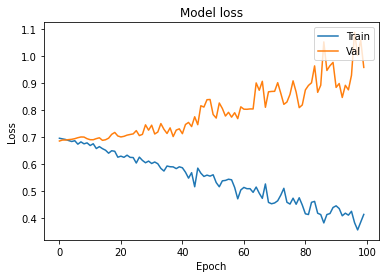

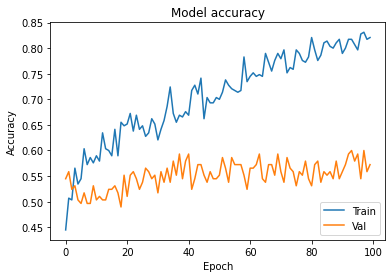

In [36]:
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [37]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

5/5 [==============================] - 0s 2ms/step - loss: 0.8920 - acc: 0.6096
Test accuracy: 0.6095890402793884


In [38]:
cell_timer = MeasureTime()
counter = 0
won = 0
lost = 0
test = model.predict(X_test)
alpha_distance = 0.35

print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')

for a in test:
    if a > (1-alpha_distance) or a < alpha_distance :
        if Y_test[counter] == 1:print('Correct prediction is Bullish')
        if Y_test[counter] == 0:print('Correct prediction is Bearish')
        if a > (1-alpha_distance):print('Model prediction is Bullish')
        if a < alpha_distance:print('Model prediction is Bearish')

        if (a > (1-alpha_distance) and Y_test[counter] == 1) or (a < alpha_distance and Y_test[counter] == 0):
            won=won+1
            print('WON')
        else:
            print('LOST')
            lost=lost+1

        d_arr = np.empty(( 0 ,4))

        d_arr = np.append(d_arr , X_test_raw[counter] , axis= 0 )
        if (counter + 1 < len(X_test_raw)):
            d_arr = np.append(d_arr , X_test_raw[counter + 1][2].reshape(1,4) , axis= 0 )

        graph_data_ohlc(d_arr)

    counter=counter+1
    
print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')
cell_timer.kill()

Won: 0 Lost: 0


ZeroDivisionError: division by zero